In [42]:
import numpy as np
import cygnus_lib as cy
import matplotlib.pyplot as plt
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
%matplotlib inline
x_resolution = y_resolution = 2048
from itertools import combinations
pixelscale  = 0.125 #55e-3 #Orange 0.125 for lemonn mm/pixel
from skimage.measure import LineModelND, CircleModel, ransac

In [43]:
import requests
import ROOT
import root_numpy as rtnp
import os
ROOT.gROOT.SetBatch(True)
def swift_root_file(sel, run):
    BASE_URL  = "https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/"
    file_root = ('Data/'+sel+'/Data_Camera/ROOT/histograms_Run%05d.root' % run)
    return BASE_URL+file_root

def swift_read_root_file(url):
    r = requests.get(url)
    tmpname = "./tmp." + str(os.getpid()) + ".root"

    with open(tmpname, 'wb') as tmp:
        tmp.write(r.content)
        f  = ROOT.TFile.Open(tmpname);
    os.remove(tmpname)
    return f
def root_TH2_name(root_file):
    name = []
    for i,e in enumerate(f.GetListOfKeys()):
        che = e.GetName()
        if ('pic_run' in str(che)):
            name.append(che)
        obj= e.ReadObj()
        if not obj.InheritsFrom('TH2'): continue
    return name


read H5 image

In [53]:
nsigma      = 1
run         = 476
traccia     = 2 #3
cimax       = 130
cimin       = 105# 85
dataSelection = 'LAB'
image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, traccia))

In [37]:

try:
    fileoutm = ("./data/run%d_mean.h5" % (run))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run)
    print ("STOP")

try: 
    fileouts = ("./data/run%d_sigma.h5" % (run))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run)
    print ("STOP")

th_image    = np.round(m_image + nsigma*s_image)

Pedestal mean: 101.84, sigma: 1.12, over th. (130) 163
Sigma mean: 2.69, sigma: 2.14, over th. (50) 90


read root file

In [4]:
run         = 940
dataSelection = 'LTD'
print ('Download and open file: '+swift_root_file("LTD", run))
f = swift_read_root_file(swift_root_file("LTD", run))
print ('Find Keys: '+str(len(f.GetListOfKeys())))
imageName = root_TH2_name(f)
print ('Find TH2: '+str(len(imageName)))
max_image=len(imageName)


Download and open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LTD/Data_Camera/ROOT/histograms_Run00940.root
Find Keys: 416
Find TH2: 208


In [26]:
nsigma      = 1
traccia     = 2 
cimax       = 130
cimin       = 95# 85
image  = rtnp.hist2array(f.Get(imageName[traccia])).T 

NameError: name 'f' is not defined

In [46]:
run_ped = 818
try:
    fileoutm = ("./data/run%d_mean.h5" % (run_ped))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

try: 
    fileouts = ("./data/run%d_sigma.h5" % (run_ped))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

th_image    = np.round(m_image + nsigma*s_image)

Pedestal mean: 98.85, sigma: 1.05, over th. (130) 180
Sigma mean: 2.51, sigma: 2.13, over th. (50) 13


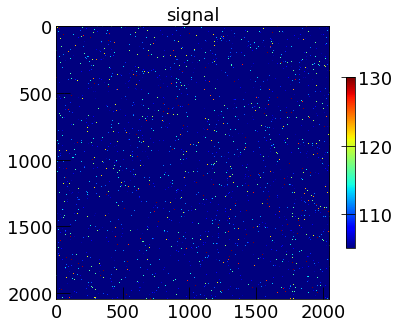

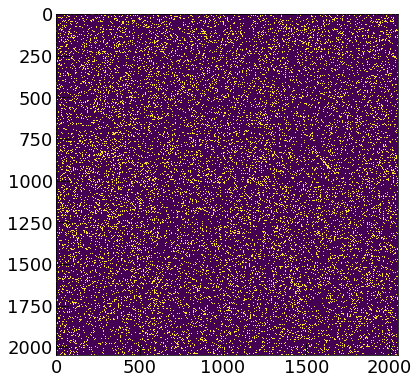

In [54]:
cy.set_atlas_style("square")
#print (nsigma, th_image)
plt.imshow(image, vmin=cimin,vmax=cimax, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("signal")
plt.show()
edges     = (image > th_image)
plt.imshow(edges, vmin=0,vmax=1)
plt.show()

main bck off image: 101.69
main track: 101.97
ph/mm track: 71.18
main left: 102.15
ph/mm left track: -9.35
main right: 101.95
ph/mm right track: -39.89


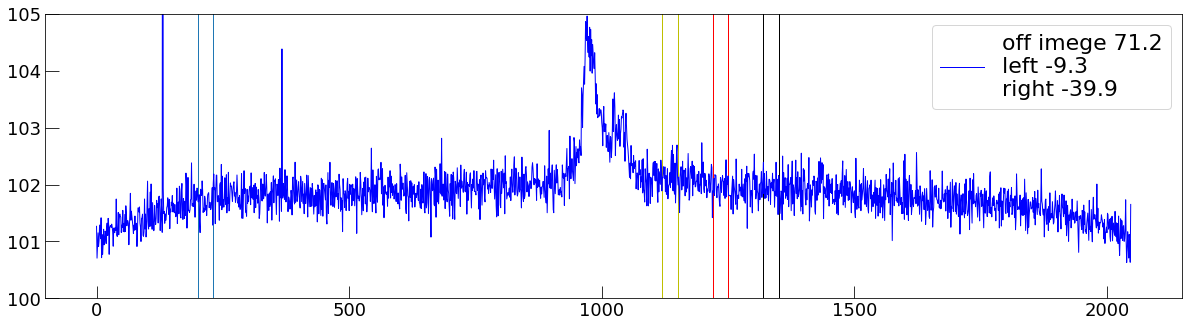

In [41]:
cy.set_atlas_style("long")
Yproj       = np.mean(image, axis=1)
x = np.arange(0, image.shape[0])
x0 = 1220
plt.axvline(x=200)
plt.axvline(x=200+30)
print("main bck off image: %.2f" % Yproj[200:230].mean())
print("main track: %.2f" % Yproj[x0:x0+30].mean())
offi=(Yproj[x0:x0+30].mean()- Yproj[200:230].mean())*2048*pixelscale
print ("ph/mm track: %.2f" % offi)
plt.axvline(x=x0, color='red')
plt.axvline(x=x0+30, color='red')
plt.axvline(x=x0-100, color='y')
plt.axvline(x=x0-100+30, color='y')
print("main left: %.2f" % Yproj[x0-100:x0-100+30].mean())
lefti = (Yproj[x0:x0+30].mean()- Yproj[900:930].mean())*2048*pixelscale
print ("ph/mm left track: %.2f" % lefti)

plt.axvline(x=x0+100, color='k')
plt.axvline(x=x0+100+30, color='k')
print("main right: %.2f" % Yproj[x0+100:x0+100+30].mean())
righti=(Yproj[x0:x0+30].mean()- Yproj[1100:1130].mean())*2048*pixelscale
print ("ph/mm right track: %.2f" % righti)
plt.plot(x, Yproj, 'b', label=('off imege %.1f\nleft %.1f\nright %.1f' % (offi, lefti, righti)))
plt.ylim(100, 105)
plt.legend()
plt.show()

(array([ 25.06940899, 961.74023169]), array([-0.01388914,  0.99990354]))


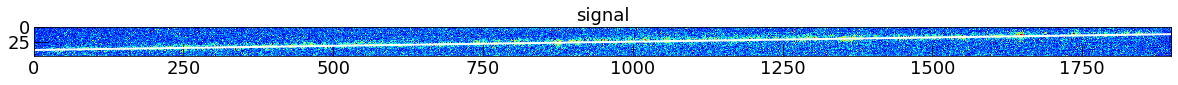

In [77]:
cy.set_atlas_style("large")
[ys,ye,xs,xe] = [950,1000, 100,2000] 
imageCutted = image[ys:ye,xs:xe]

edges     = (imageCutted > 105) # NEGATVE per settori imageCutted < 108
points    = np.array(np.nonzero(edges)).T.astype(float)


model = LineModelND()
model.estimate(points)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(points, LineModelND, min_samples=2,
                               residual_threshold=5, max_trials=1000)
outliers = inliers == False


line_x = np.arange(0, imageCutted.shape[1])
#line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)
q,m = model_robust.params
print(model_robust.params)

fig, ax = plt.subplots()
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
#plt.colorbar(shrink=0.6)
#ax.plot(points[inliers, 1], points[inliers, 0], '.k', alpha=0.6,
#        label='Inlier data', markersize=6)
#ax.plot(points[outliers, 1], points[outliers, 0], '.y', alpha=0.6,
#        label='Outlier data', markersize=6)
#ax.plot(line_y, line_x, '-y', label='Line model from all data')
ax.plot(line_y_robust, line_x, '-w', label='line fit', linewidth=2)
#ax.legend()
plt.xlim(0,imageCutted.shape[1]-1)
plt.ylim(imageCutted.shape[0]-1,0)
plt.title("signal")
plt.show()

# eventuale rotazione m coefficiente del fit

offsset: -28
offsset: -18
offsset: -22


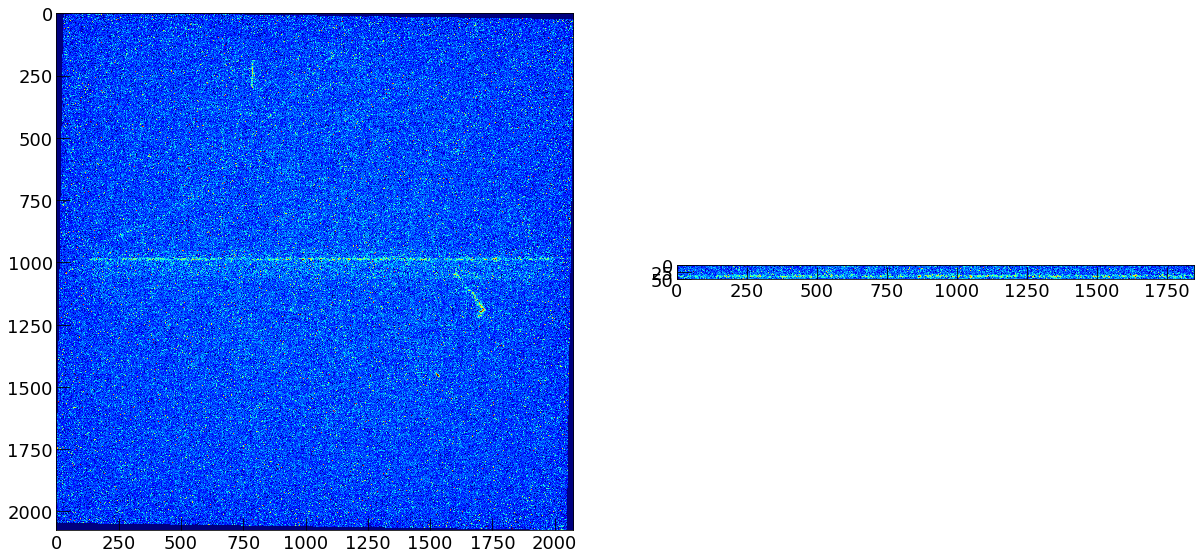

In [78]:
import scipy.ndimage

theta  = np.arctan(m[0])*(180.0/np.pi)
imgR   = scipy.ndimage.interpolation.rotate(image, theta)
m_imgR = scipy.ndimage.interpolation.rotate(m_image, theta)
s_imgR = scipy.ndimage.interpolation.rotate(s_image, theta)
print ("offsset: %d" % (x_resolution*m[0]))
print ("offsset: %d" % (1300*m[0]))
print ("offsset: %d" % (1600*m[0]))
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgR, vmin=cimin,vmax=cimax, cmap='jet')
ax[1].imshow(imgR[(ys+int((ye-ys)*m[0])):
                  (ye-int((ye-ys)*m[0])),
                  (xs-int((xe-xs)*m[0])):
                  (xe+int((xe-xs)*m[0]))], 
             vmin=cimin,vmax=cimax, cmap='jet')
plt.show()

Th mean = 101.39, sigma = 5.00
Signal: 438019 photons 3981.99 keV
Mean/sigma signal 103.66/4.10, Mean/sigma bck 98.92/4.52


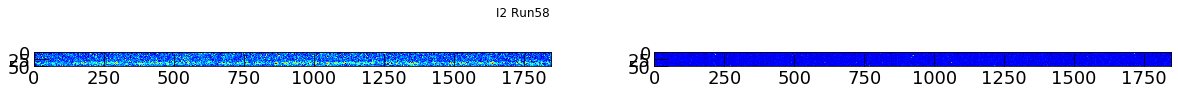

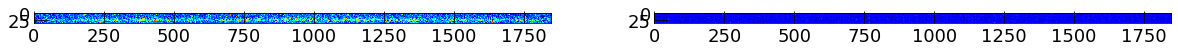

Image lenght: 231.00 [mm]
Signal: 348252 photons ==> 1507.59 [ph/mm]


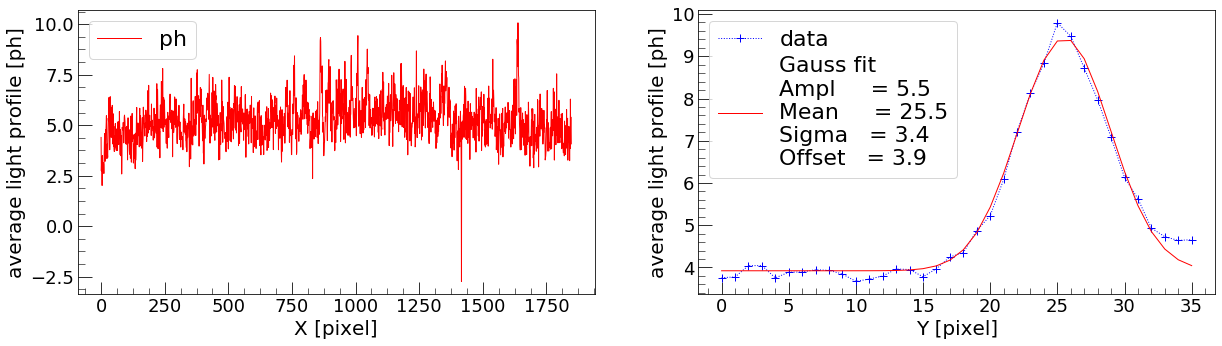

Int light in X: 9668.80 [ph*pixel]
Int light in Y: 184.24 [ph*pixel]
Light, X: 340478.29 / Y: 348076.92 [ph]


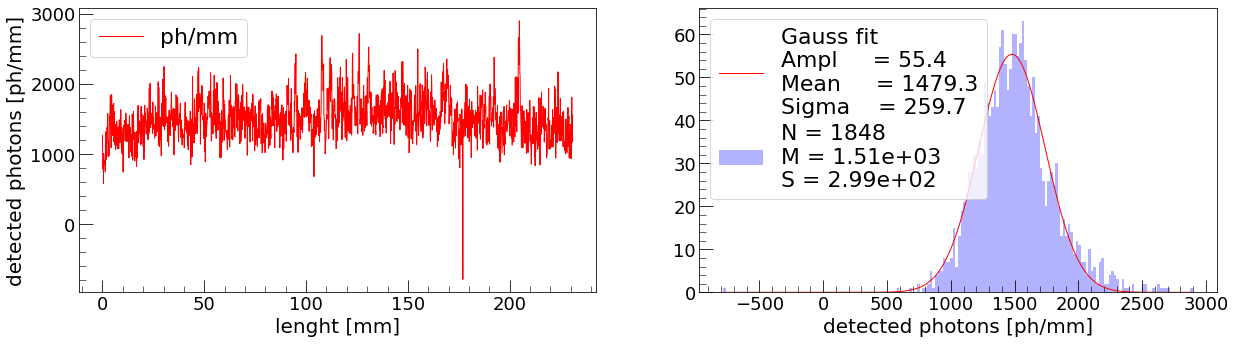

In [81]:

cy.set_atlas_style('long')

#### figura 3 run 740 alfettissima [945:970,1375:1405] 
ibck        = m_image[945:970,1375:1405]
imageCutted = image[945:970,1375:1405]
th_image  = np.round(m_image + nsigma*s_image)[945:970,1375:1405]
#### figura 3 run 740 alfetta [1330:1370,390:430]
#ibck        = m_image[1330:1370,390:430]
#imageCutted = image[1330:1370,390:430]
#th_image  = np.round(m_image + nsigma*s_image)[1330:1370,390:430]
#### figura 3 run 740 protone [1600:1680,1300:1490]
#ibck        = m_image[1600:1680,1300:1490]
#imageCutted = image[1600:1680,1300:1490]
#th_image    = np.round(m_image + nsigma*s_image)[1600:1680,1300:1490]
#### figura 3 run 740 protone [1600:1680,1300:1490] rotaed
#ibck        = m_imgR[1710:1790,1680:1490+400]
#imageCutted = imgR[1710:1790,1680:1490+400]
#th_image    = np.round(m_imgR + nsigma*s_imgR)[1710:1790,1680:1490+400]
##### figura 3 run 740 alfona [650:690,700:950]
#ibck        = m_image[650:690,700:950]
#imageCutted = image[650:690,700:950]
#th_image    = np.round(m_image + nsigma*s_image)[650:690,700:950]
###### figura 53 run 740 alfetta [950:1000, 700:760]
#ibck        = m_image[950:1000, 700:760]
#imageCutted = image[950:1000, 700:760]
#th_image    = np.round(m_image + nsigma*s_image)[950:1000, 700:760]
####### figura 6 run 88 [800:900, 200:2000]
#ibck        = m_image[830:890, 200:2000]
#imageCutted = image[830:890, 200:2000]
#th_image    = np.round(m_image + nsigma*s_image)[830:890, 200:2000]
####### figura 6 run 87 [1000:1100, 200:2000]
#ibck        = m_image[1015:1065, 200:2000]
#imageCutted = image[1015:1065, 200:2000]
#th_image    = np.round(m_image + nsigma*s_image)[1015:1065, 200:2000]
####### figura 5 run 87 [1000:1100, 200:2000]
#ibck        = m_image[1000:1050, 200:2000]
#imageCutted = image[1000:1050, 200:2000]
#th_image    = np.round(m_image + nsigma*s_image)[1000:1050, 200:2000]
####### figura 5 run 87 [970:1070, 100:2000]
#ibck        = m_image[170:270, 100:2000]
#imageCutted = image[970:1070, 100:2000]
#th_image    = np.round(m_image + nsigma*s_image)[170:270, 100:2000]
####### figura 5 run 87 [970:1070, 100:2000]
#ibck        = m_imgR[200:270, 100:2000]
#imageCutted = imgR[1000:1070, 100:2000]
#th_image    = np.round(m_imgR + nsigma*s_imgR)[200:270, 100:2000]


imageCutted = imgR[abs(ys+int((ye-ys)*m[0])):
                  abs(ye-int((ye-ys)*m[0])),
                  abs(xs-int((xe-xs)*m[0])):
                  abs(xe+int((xe-xs)*m[0]))]

ybck        = 900
ibck        = m_imgR[
                  ybck:
                  ybck+imageCutted.shape[0],
                  abs(xs-int((xe-xs)*m[0])):
                  abs(xe+int((xe-xs)*m[0]))]

th_image    = np.round(m_imgR + nsigma*s_imgR)[
                  ybck:
                  ybck+imageCutted.shape[0],
                  abs(xs-int((xe-xs)*m[0])):
                  abs(xe+int((xe-xs)*m[0]))]



print ("Th mean = %.2f, sigma = %.2f" % (th_image.mean(), np.sqrt(th_image.var())))

#### Nonalizzazioni 450 0.1 ph/keV
print ("Signal: %d photons %.2f keV" % (imageCutted.sum()-ibck.sum(), (imageCutted.sum()-ibck.sum())/(0.11*1000)))
#
print("Mean/sigma signal %.2f/%.2f, Mean/sigma bck %.2f/%.2f" % (imageCutted.mean(), imageCutted.std(), 
                                                                ibck.mean(), ibck.std()))

fig, ax = plt.subplots(1,2)

im = ax[0].imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
im = ax[1].imshow(ibck, vmin=cimin,vmax=cimax, cmap='jet')
#fig.colorbar(im, ax=ax)
plt.suptitle("I%d Run%d" % (traccia, run), y=0.7)
plt.show()
######################################################
Yproj       = np.mean(imageCutted-ibck, axis=1)
y0  = np.argmax(Yproj)
dy0 = 25
imageCutted2 = imageCutted[y0-dy0:y0+dy0,]
ibck2        = ibck[y0-dy0:y0+dy0,]

fig, ax = plt.subplots(1,2)

im = ax[0].imshow(imageCutted2, vmin=cimin,vmax=cimax, cmap='jet')
im = ax[1].imshow(ibck2, vmin=cimin,vmax=cimax, cmap='jet')
plt.show()
print ("Image lenght: %.2f [mm]" % (imageCutted2.shape[1]*pixelscale))

print ("Signal: %d photons ==> %.2f [ph/mm]" % (imageCutted2.sum()-ibck2.sum(), 
                                                (imageCutted2.sum()-ibck2.sum())/
                                                (imageCutted2.shape[1]*pixelscale)))


fig, ax = plt.subplots(1,2)
#
Xproj       = np.mean(imageCutted2-ibck2, axis=0)
Yproj       = np.mean(imageCutted2-ibck2, axis=1)

xx          = np.arange(0, imageCutted2.shape[1])
xy          = np.arange(0, imageCutted2.shape[0])
#

ax[0].plot(xx, Xproj, 'r-', label='ph')
ax[0].set_ylabel('average light profile [ph]')
ax[0].set_xlabel('X [pixel]')
ax[0].minorticks_on()
ax[0].legend()

x0 = np.argmax(Yproj)
s0 = 5
a0 = max(Yproj)
y0 = Yproj.mean()

ax[1].plot(xy, Yproj, 'b+:', label='data')
try:
    popt,pcov = curve_fit(my.Gauss, xy, Yproj, p0=[a0, x0, s0, y0])
    ax[1].plot(xy, my.Gauss(xy, *popt), 'r-',
           label='Gauss fit   \nAmpl     = %.1f\nMean     = %.1f\nSigma   = %.1f\nOffset   = %.1f' %
           (popt[0], popt[1], popt[2], popt[3]))
except:
    print (">>> FIT ERROR <<<")

ax[1].set_xlabel('Y [pixel]')
ax[1].set_ylabel('average light profile [ph]')
ax[1].minorticks_on()
ax[1].legend()
plt.show()


fig, ax = plt.subplots(1,2)
DDY = np.trapz(Yproj,xy)
DDX = np.trapz(Xproj,xx)
print("Int light in X: %.2f [ph*pixel]" % DDX)
print("Int light in Y: %.2f [ph*pixel]" % DDY)
print("Light, X: %.2f / Y: %.2f [ph]" % (DDY*xx.size, DDX*xy.size))


eres = Xproj*xy.size/pixelscale

ax[0].plot(xx*pixelscale, eres, 'r-', label='ph/mm')
ax[0].set_ylabel('detected photons [ph/mm]')
ax[0].set_xlabel('lenght [mm]')
ax[0].legend()
ax[0].minorticks_on()
bins = int(eres.size/10)
ax[1].hist(eres, bins=bins, color='blue', alpha=0.3, label='N = %d\nM = %.2e\nS = %.2e' % 
       (np.size(eres), np.mean(eres), np.sqrt(np.var(eres))))
x    = np.linspace(eres.min(), eres.max(), bins)
y, _ = np.histogram(eres, bins=bins)
a0 = np.max(y)
x0 = np.mean(eres)
s0 = np.sqrt(np.var(eres))
try:
    popt,pcov = curve_fit(my.Gauss3, x, y, p0=[a0, x0, s0])
    x = np.linspace(eres.min(), eres.max(), bins)
    ax[1].plot(x, my.Gauss3(x, *popt), 'r-',
           label='Gauss fit   \nAmpl     = %.1f\nMean     = %.1f\nSigma    = %.1f' %
           (popt[0], popt[1], popt[2]))
except:
    print("fit error")

ax[1].set_xlabel('detected photons [ph/mm]')
ax[1].minorticks_on()
ax[1].legend()
plt.show()

In [ ]:


#nsigma    = 1.0  ####### se si vuole cambaire cut
#th_image  = np.round(m_image + nsigma*s_image)

#### figura 3 run 740 alfettissima [945:970,1375:1405]
ibck        = m_image[945:970,1375:1405]
imageCutted = image[945:970,1375:1405]
th_image  = np.round(m_image + nsigma*s_image)[945:970,1375:1405]

#### figura 3 run 740 alfetta [1330:1370,390:430]
#ibck        = m_image[1330:1370,390:430]
#imageCutted = image[1330:1370,390:430]
#th_image  = np.round(m_image + nsigma*s_image)[1330:1370,390:430]
#### figura 3 run 740 protone [1500:1750,1250:1500]
#ibck        = m_image[1500:1750,1250:1500]
#imageCutted = image[1500:1750,1250:1500]
#th_image    = np.round(m_image + nsigma*s_image)[1500:1750,1250:1500]
#### figura 3 run 740 alfona [600:1000,600:1000]
#ibck        = m_image[500:900,600:1000]
#imageCutted = image[500:900,600:1000]
#th_image    = np.round(m_image + nsigma*s_image)[500:900,600:1000]
#########
ibck        = m_image[950:1000, 700:760]
imageCutted = image[950:1000, 700:760]
th_image    = np.round(m_image + nsigma*s_image)[950:1000, 700:760]
###### figura 5 run 87 [970:1070, 100:2000]
ibck        = m_image[170:270, 100:2000]
imageCutted = image[970:1070, 100:2000]
th_image    = np.round(m_image + nsigma*s_image)[170:270, 100:2000]


print (imageCutted.shape[0], th_image.shape[0])


edges     = (imageCutted > th_image) & (imageCutted < cimax)
points    = np.array(np.nonzero(edges)).T.astype(float)

In [ ]:
cy.set_atlas_style()
plt.plot(points[:,1], points[:,0], "k.", markersize=1)
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
plt.show()

In [ ]:
cy.set_atlas_style()
from skimage.measure import LineModelND, ransac
model = LineModelND()
model.estimate(points)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(points, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
print(model.params)
print(model_robust.params)
outliers = inliers == False

# generate coordinates of estimated models
line_x = np.arange(0, imageCutted.shape[1])
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
ax.plot(points[inliers, 1], points[inliers, 0], '.k', alpha=0.6,
        label='Inlier data', markersize=6)
ax.plot(points[outliers, 1], points[outliers, 0], '.y', alpha=0.6,
        label='Outlier data', markersize=6)
ax.plot(line_y, line_x, '-y', label='Line model from all data')
ax.plot(line_y_robust, line_x, '-k', label='Robust line model')
ax.legend()
plt.xlim(0,imageCutted.shape[1]-1)
plt.ylim(imageCutted.shape[0]-1,0)
plt.show()

In [ ]:
cy.set_atlas_style("long")
plt.imshow(image[650:690,700:950], vmin=90,vmax=250, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("signal")
plt.show()
plt.imshow(m_image[650:690,700:950], vmin=95,vmax=105, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("pdestal")
plt.show()
plt.imshow(s_image[650:690,700:950], vmin=0,vmax=15, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("sigma pdestal")
plt.show()
plt.imshow(th_image, vmin=90,vmax=120, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("dinamic threshold")
plt.show()

In [ ]:
np.ones((5,))